# <span style="color:green"><center>Diplomado en Inteligencia Artificial y Aprendizaje Profundo</center></span>

# <span style="color:red"><center>Predicción del valor de una acción a tres días. Apple (LSTM)</center></span>

##   <span style="color:blue">Profesores</span>

1. Alvaro Mauricio Montenegro Díaz, ammontenegrod@unal.edu.co
2. Daniel Mauricio Montenegro Reyes, dextronomo@gmail.com 
3. Campo Elías Pardo Turriago, cepardot@unal.edu.co 

##   <span style="color:blue">Asesora Medios y Marketing digital</span>
 

4. Maria del Pilar Montenegro, pmontenegro88@gmail.com 

## <span style="color:blue">Asistentes</span>

5. Oleg Jarma, ojarmam@unal.edu.co 
6. Laura Lizarazo, ljlizarazore@unal.edu.co 

## <span style="color:blue">Referencias</span>

1. [Introducción a Redes LSTM](Intro_LSTM.ipynb)
1. [Time Series Forecasting with LSTMs using TensorFlow 2 and Keras in Python](https://towardsdatascience.com/time-series-forecasting-with-lstms-using-tensorflow-2-and-keras-in-python-6ceee9c6c651/)
1. [Dive into Deep Learnig](https://d2l.ai/)
1. [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
1. Ralf C. Staudemeyer and Eric Rothstein Morris,[*Understanding LSTM a tutorial into Long Short-Term Memory Recurrent Neural Networks*](https://arxiv.org/pdf/1909.09586.pdf), arxiv, September 2019
1. Karpathy, [*The Unreasonable Effectiveness of Recurrent Neural Networks*](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
1. Anton Lucanus, [Making Automation More Efficient by Learning from Historical Trade Data](https://datafloq.com/read/making-automation-more-efficient-by-learning-from-/7444), 8:43 AM, January 7, 2020
1. https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/
1. https://www.youtube.com/watch?v=2BrpKpWwT2A&list=PLQVvvaa0QuDcOdF96TBtRtuQksErCEBYZ&index=1
1. https://towardsdatascience.com/using-lstms-for-stock-market-predictions-tensorflow-9e83999d4653
1. https://github.com/llSourcell/Reinforcement_Learning_for_Stock_Prediction/blob/master/README.md

## <span style="color:blue">Contenido</span>

* [Introducción](#Introducción)
* [Importar las librería requeridas](#Importar-las-librería-requeridas)
* [Funciones-para-graficar-predicciones](#Funciones-para-graficar-predicciones)
* [Lectura de los datos](#Lectura-de-los-datos)
* [Extrae datos para la serie que se desea predecir-close](#Extrae-datos-para-la-serie-que-se-desea-predecir-close)
* [Visualización de la serie precio al cierre](#Visualización-de-la-serie-precio-al-cierre)
* [Preparación de los datos para el entrenamiento](#Preparación-de-los-datos-para-el-entrenamiento)
* [Crea el modelo LSTM](#Crea-el-modelo-LSTM)
* [Lee modelo preentrenado a un día](#Lee-modelo-preentrenado-a-un-día)
* [Predicciones](#Predicciones)
* [Guarda el modelo entrenado](#Guarda-el-modelo-entrenado)
* [Intervalos de confianza. TO DO](#Intervalos-de-confianza.-TO-DO)

## <span style="color:blue">Importar las librería requeridas</span>

In [2]:
#
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#importing required libraries
from sklearn.preprocessing import MinMaxScaler

# importa objetos de keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM
print("Versión de Tensorflow: ", tf.__version__)

# optimizador
from tensorflow.keras.optimizers import Adam

Versión de Tensorflow:  2.4.1


## <span style="color:blue">Lectura de  los datos</span>

Estos datos corresponden a la empresa *Apple*. Son  3019 datos que corresponden a observaciones del precio de la acción, el número de transacciones de la acción (compra-venta). Los datos son diarios (dias hábiles o comerciales). Están entre el 3 de enero de 2006 hasta el 1 de enero de 2018.

la columna *Date* es la fecha, *Open* es el valor de acción a la apertura del mercado, *High* el valor más alto alcanzado en el día, *Low* el valor más bajo del día, *Close* el valor al cierre,  *Volume* es el volúmenes de acciones transadas en el día  y *Name* es el código de identificación de la empresa, Apple en este caso.


Los datos puede ser bajados directamente de [Kaggle](https://www.kaggle.com/szrlee/stock-time-series-20050101-to-20171231)

In [5]:
#reading from a local file

df = pd.read_csv('../Datos/AAPL_2006-01-01_to_2018-01-01.csv')


In [6]:
# looking at the first five rows of the data
print('\n Shape of the data:')
print(df.shape)
df.head()


 Shape of the data:
(3019, 7)


,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
1,2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2,2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
3,2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
4,2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


Vamos a cambiar el índice de los datos. Tomaremos la fecha como indice: *df.index*. Los datos se reordenan para invertir la tabla, debido a que los datos contienen las observaciones más recientes en la parte superior de la tabla.

## <span style="color:blue">Extrae datos para la serie que se desea predecir-close</span>

In [7]:
#creating dataframe with date and the target variable

df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']
# df = df.sort_index(ascending=True, axis=0)
data = pd.DataFrame(df[['Date', 'Close']])
#
#setting index
data.index = data.Date
data.drop('Date', axis=1, inplace=True)
data.head()

,Close
Date,
2006-01-03,10.68
2006-01-04,10.71
2006-01-05,10.63
2006-01-06,10.90
2006-01-09,10.86


## <span style="color:blue">Visualización de la serie precio al cierre</span>


In [8]:
# plot
len_data = len(data)
len_train = int(len_data*0.8) # 80%  = 3019
len_test = len_data- len_train # 20% = 2415
print (len_data, '=', len_train, '+',len_test)

3019 = 2415 + 604


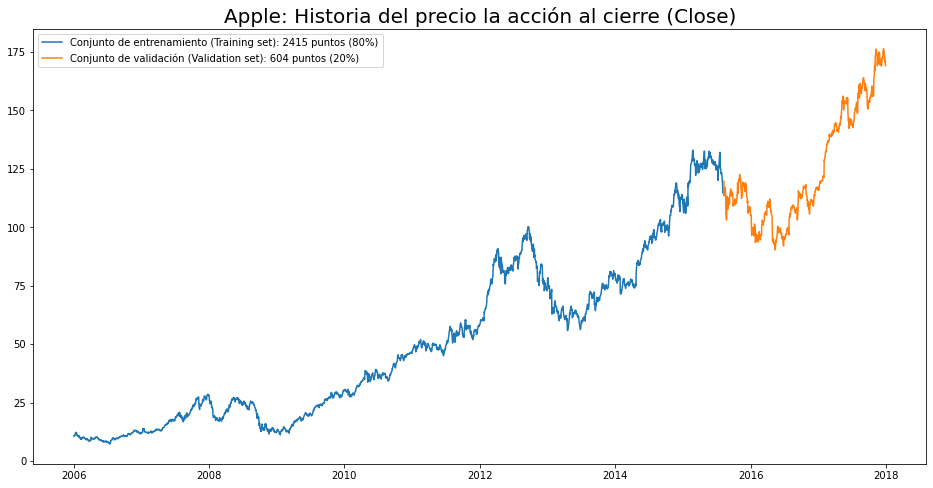

In [9]:
plt.figure(figsize=(16,8))
plt.plot(data[:len_train], label='Conjunto de entrenamiento (Training set): {} puntos (80%)'.format(len_train))
plt.plot(data['Close'][len_train:], label='Conjunto de validación (Validation set): {} puntos (20%)'.format(len_test)) #248 data
plt.title("Apple: Historia del precio la acción al cierre (Close)", size = 20)
plt.legend()
plt.show()

## <span style="color:blue">Preparación de los datos para el entrenamiento de la red LSTM</span>

Para evitar problemas con las tendencias y para mejorar la estimación (entrenamiento) los datos se van a transformar a la escala $[0,1]$. Para las predicciones se utiliza la transformación inversa.

### Primero extrae los valores y se crea el  objeto MinMaxScaler

In [10]:
#creating train and test sets
dataset = data.values


# create the scaler object and scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
#scaled_data = np.array(scaler.fit_transform(dataset))
dataset = np.squeeze(np.array(scaler.fit_transform(dataset)),axis=1)
# dataset = pd.DataFrame(scaled_data,index=data.index, columns=['serie'])

In [11]:
dataset.shape

(3019,)

###  Crea datos de entrenamiento 

 La red LSTM tendrá como entrada "time_step" datos consecutivos, y como salida 5 datos (la predicción a
 partir de esos "time_step" datos se hace para los siguentes 5 días). Se conformará de esta forma el set de entrenamiento

1. Número de datos consecutivos para entrenamiento: time_step = 60. 
2. Días a predecir: days = 1

### Función para crear los datos entrenamiento

In [12]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

Se coloca una semilla para gerantizar reproductibidad

In [8]:
tf.random.set_seed(100)

In [15]:
#
# hiperparámetros para crear las secuencias
past_history = 60 # tamaño secuencias de entrada
future_target = 3 # días adelante
TRAIN_SPLIT = int(len_data*0.8) #2415: nuḿer0 de datos entreno

# secuencias de entrenamiento
X_train, y_train = univariate_data(dataset, 0, TRAIN_SPLIT,
                                           past_history,
                                           future_target)
#
#secuencias de validación
# No se usará ningún dato que el modelo haya visto
X_test, y_test = univariate_data(dataset, TRAIN_SPLIT, None,
                                       past_history,
                                       future_target)

print(TRAIN_SPLIT)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

2415
(2355, 60, 1)
(2355,)
(541, 60, 1)
(541,)


## <span style="color:blue">Crea el modelo LSTM</span>

Omitimos esta sección. Usaremso el modelo entrenado a un día

In [43]:
# shapes
input_shape = (X_train.shape[1], X_train.shape[2])
units = 50

# layers
inputs = Input(input_shape)
x = Dropout(0.0, name= 'Dropout_01')(inputs)
x = LSTM(units=units, name='LSTM_layer')(x)
#x = LSTM(units=units, return_sequences=True,name='LSTM_layer')(inputs)
#x = Dropout(0.4)
#x = LSTM(units=units//2, name='LSTM_layer_2')(x)
#x = Dropout(0.4)
x = Dropout(0.0, name= 'Dropout_02')(x)
outputs = Dense(1)(x)

# model
model_01 = Model(inputs=inputs, outputs=outputs, name='series_LSTM_model')
model_01.summary()


Model: "series_LSTM_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 60, 1)]           0         
_________________________________________________________________
Dropout_01 (Dropout)         (None, 60, 1)             0         
_________________________________________________________________
LSTM_layer (LSTM)            (None, 50)                10400     
_________________________________________________________________
Dropout_02 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


##  Compila

Se usará el optimizador Adam y la función de pérdida MSE

In [44]:
model_01.compile(loss='mean_squared_error',
  optimizer=Adam(0.001))


## <span style="color:blue">Lee modelo preentrenado a un día</span>

In [14]:
from tensorflow.keras.models import load_model

model_01 = load_model('../Datos/modelo_Apple_1_dia.h5')

### Entrena el modelo

In [16]:
#history = model_01.fit(X_train,y_train,epochs=20,batch_size=32)
history = model_01.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Epoch 1/40
67/67 [==============================] - 25s 250ms/step - loss: 2.9799e-04 - val_loss: 4.2615e-04
Epoch 2/40
67/67 [==============================] - 15s 224ms/step - loss: 2.4531e-04 - val_loss: 4.5936e-04
Epoch 3/40
67/67 [==============================] - 16s 234ms/step - loss: 3.2693e-04 - val_loss: 4.4569e-04
Epoch 4/40
67/67 [==============================] - 11s 171ms/step - loss: 2.6917e-04 - val_loss: 4.3797e-04
Epoch 5/40
67/67 [==============================] - 12s 177ms/step - loss: 3.7866e-04 - val_loss: 4.3236e-04
Epoch 6/40
67/67 [==============================] - 12s 184ms/step - loss: 2.8073e-04 - val_loss: 4.5449e-04
Epoch 7/40
67/67 [==============================] - 12s 180ms/step - loss: 3.9535e-04 - val_loss: 4.1761e-04
Epoch 8/40
67/67 [==============================] - 13s 187ms/step - loss: 2.6136e-04 - val_loss: 4.3926e-04
Epoch 9/40
67/67 [==============================] - 12s 180ms/step - loss: 3.2737e-04 - val_loss: 4.2956e-04
Epoch 10/40
67/67 [

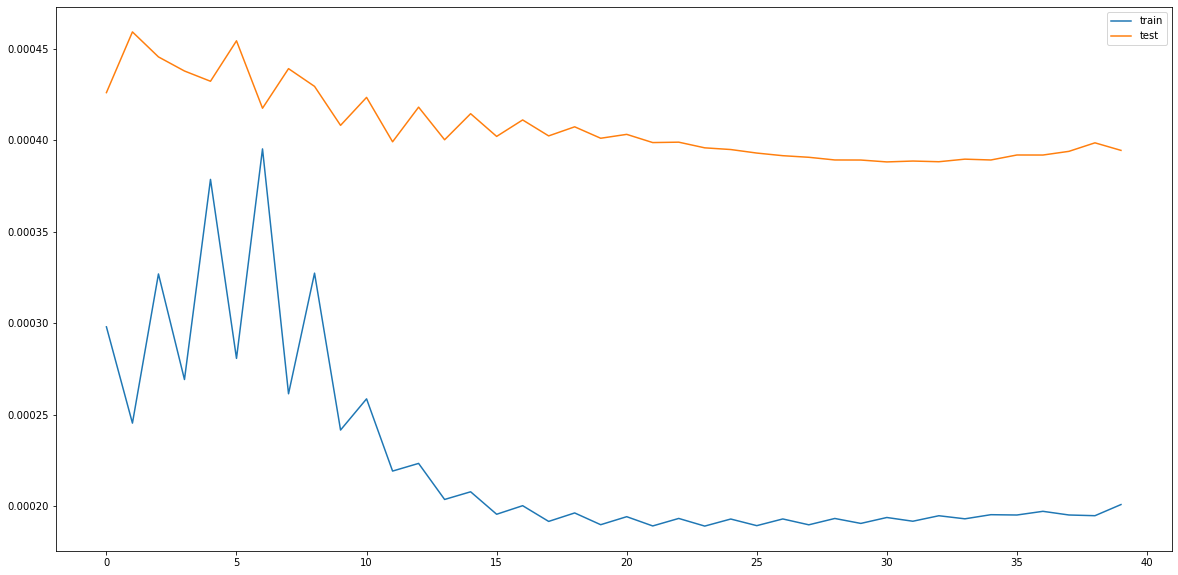

In [17]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

## <span style="color:blue">Predicciones</span>

### Prepara los datos de validación

In [18]:
X_test.shape

(541, 60, 1)

### Calcula predicciones

In [19]:
# predictions
prediction = model_01.predict(X_test)
#prediction = scaler.inverse_transform(prediction)

In [20]:
print(prediction.shape)
print(y_test.shape)


(541, 1)
(541,)


### elimina dimensiones sobrante para los gráficos

In [21]:
y_train_p = y_train# np.squeeze(y_train, axis=-1)
y_test_p = y_test #np.squeeze(y_test, axis=-1)
y_pred_p = np.squeeze(prediction, axis=-1)

In [22]:
print(y_train_p.shape)
print(y_test_p.shape)
print(y_pred_p.shape)

k=0
for i,j in zip(y_test_p, y_pred_p):
    print (i,j, i-j)
    k+=1
    if k==10:
        break

(2355,)
(541,)
(541,)
0.6727745596406196 0.67634654 -0.0035719808104301976
0.6698782361981322 0.6805849 -0.010706671333606033
0.6474169523584349 0.68006444 -0.03264748741512469
0.6435157820073296 0.6745708 -0.03105501686657175
0.6412105449816764 0.67076415 -0.029553603253644645
0.6212318240926825 0.6689307 -0.04769888526934751
0.6321078141624307 0.65813744 -0.02602962651902685
0.6292114907199433 0.6481363 -0.01892482701000664
0.6504906017259725 0.6432964 0.0071941811517842735
0.6592977893368012 0.6338896 0.02540817380106508


### Gráfica de las predicciones

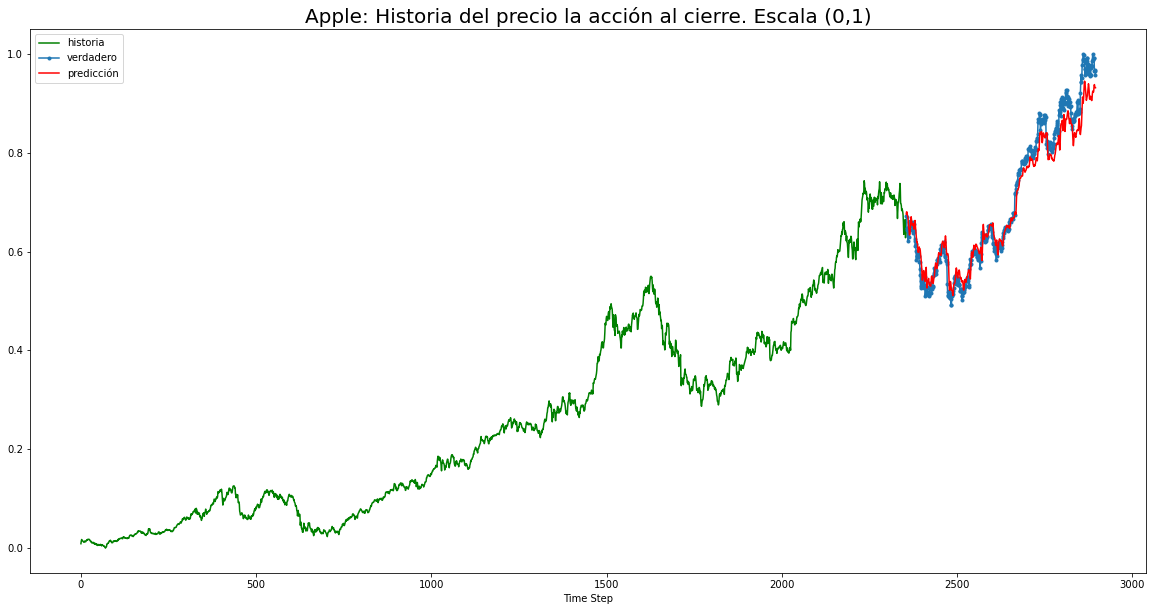

In [23]:
plt.plot(np.arange(0, len(y_train_p)), y_train_p, 'g', label="historia")
plt.plot(np.arange(len(y_train_p), len(y_train_p) + len(y_test_p)), y_test_p, marker='.', label="verdadero")
plt.plot(np.arange(len(y_train_p), len(y_train_p) + len(y_test_p)), y_pred_p, 'r', label="predicción")
#plt.ylabel('Valor')
plt.xlabel('Time Step')
plt.title("Apple: Historia del precio la acción al cierre. Escala (0,1)", size = 20)
plt.legend()
plt.show();

## Regreso a la escala original

In [24]:
y_pred_or = scaler.inverse_transform(y_pred_p.reshape(-1,1))
y_test_or = scaler.inverse_transform(y_test_p.reshape(-1,1))

In [25]:
k=0
for i,j in zip(y_test_or, y_pred_or):
    print (i,j, i-j)
    k+=1
    if k==10:
        break

[121.06] [121.66431] [-0.60430664]
[120.57] [122.381355] [-1.81135529]
[116.77] [122.2933] [-5.52329681]
[116.11] [121.363884] [-5.25388397]
[115.72] [120.71988] [-4.99987915]
[112.34] [120.4097] [-8.06969849]
[114.18] [118.58369] [-4.40368683]
[113.69] [116.8917] [-3.20170074]
[117.29] [116.07288] [1.21711639]
[118.78] [114.481445] [4.29855469]


In [26]:
rmsLSTM = np.sqrt(np.mean(np.power(y_pred_or-y_test_or,2)))
print(rmsLSTM )

5.41433370144573


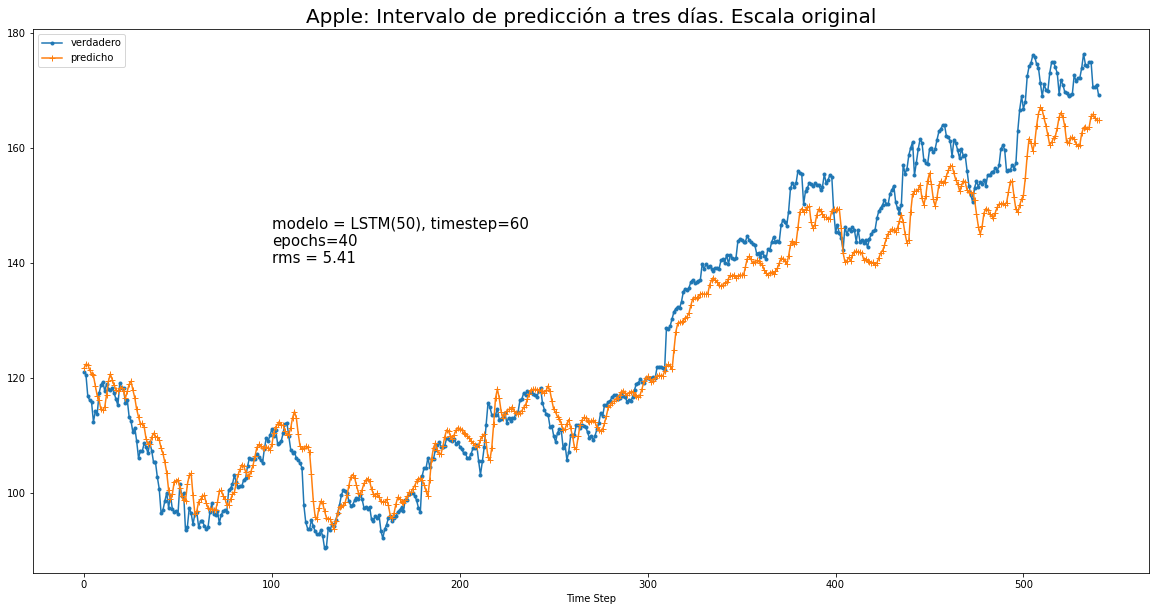

In [27]:
plt.plot(np.arange(0, len(y_test_or)), y_test_or, marker='.', label="verdadero")
plt.plot(np.arange(0, len(y_test_or)), y_pred_or, marker='+', label="predicho")
plt.xlabel('Time Step')
plt.annotate("rms = "+str(round(rmsLSTM,2)) , xy=(100, 140), size = 15)
plt.annotate("modelo = LSTM(50), timestep=60" , xy=(100, 146), size = 15)
plt.annotate("epochs=40" , xy=(100, 143), size = 15)
plt.title("Apple: Intervalo de predicción a tres días. Escala original", size = 20)
plt.legend()
plt.show();

## <span style="color:blue">Guarda el modelo entrenado</span>

In [28]:
model_01.save('../Datos/modelo_Apple_3_dia.h5')

## <span style="color:blue">Intervalos de confianza. TO DO</span>

In [ ]:
model_01.get_config()